In [1]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import torch
torch.set_float32_matmul_precision('high')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from os.path import join

import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier
from utils import get_best_ckpts

/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [4]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'
LOGS_PATH = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default'
CKPT_PATHS = get_best_ckpts(LOGS_PATH, [f'w_augment_{i}' for i in range(1, 6)])

In [5]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

# Get ensembl predictions

In [6]:
import gc


def get_ensemble_preds(ckpts, dataloader=None):
    estim = EstimatorCellTypeClassifier(DATA_PATH)
    estim.init_datamodule(batch_size=2048)
    estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

    probas = []

    for ckpt in ckpts:
        estim.model = TabnetClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('tabnet'))
        probas.append(estim.predict(estim.datamodule.test_dataloader() if dataloader is None else dataloader))
        gc.collect()

    return np.stack(probas, axis=-1).mean(axis=-1), np.stack(probas, axis=-1)


In [7]:
probas, probas_per_model = get_ensemble_preds(CKPT_PATHS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 1684/1684 [04:11<00:00,  6.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 1684/1684 [04:06<00:00,  6.83it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 1684/1684 [03:49<00:00,  7.35it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 1684/1684 [03:48<00:00,  7.35it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 1684/1684 [03:47<00:00,  7.39it/s]


# Evaluate performance

Evaluate classification of ensemble model

In [8]:
from utils import correct_labels

In [9]:
y_pred = np.argmax(probas, axis=1)
y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)

### Overall performance

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

In [11]:
clf_report = pd.DataFrame(classification_report(y_true, y_pred_corr, output_dict=True)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

clf_report_overall

,precision,recall,f1-score,support
accuracy,0.916361,0.916361,0.916361,9.163610e-01
macro avg,0.842414,0.863599,0.845922,3.448832e+06
weighted avg,0.920432,0.916361,0.916324,3.448832e+06


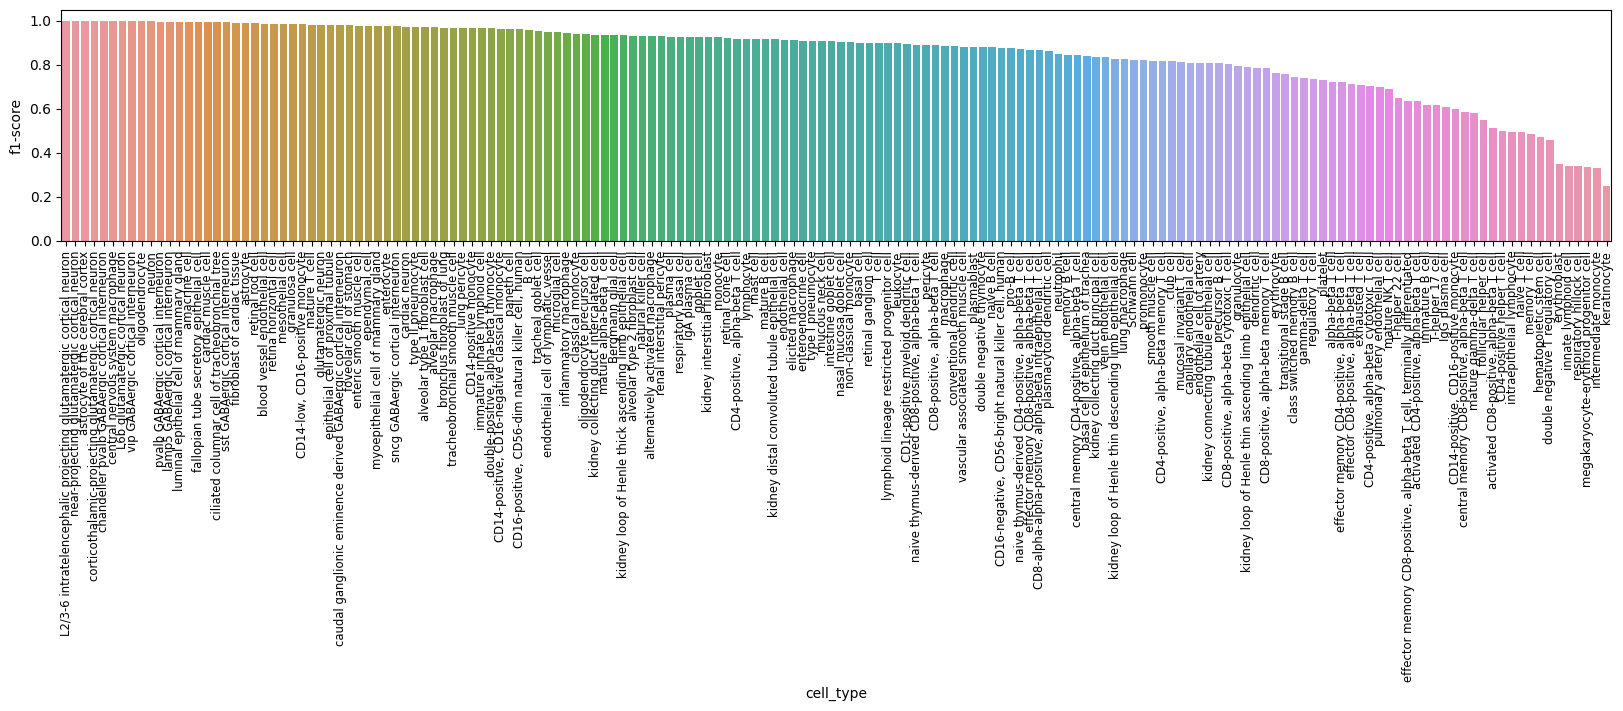

In [12]:
plt.rcParams['figure.figsize'] = (20, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
)
ax.tick_params(axis='x', labelrotation=90)
ax.xaxis.set_tick_params(labelsize='small');

# Evaluate uncertainty estimates

**Data divisions:**

* In-distribution (`right` predictions)
    * Test data (unseen donors) subset to `right` predictions
    * Consists only of known cell types
* In-distribution (`wrong` predictions)
    * Test data (unseen donors) subset to `wrong` predictions
    * Consists only of known cell types.
* Out-of-distribution (OOD)
    * Consists of cells which are not included in the training, validation or test data
    * Consists of unknown cell types (not seen during training)
    * It's impossible for the network to predict those cell types exactly as it is not trained on those labels
    * This is supposed to simulate new unknown cell types (cell types that don't fully fit any of the cell types the model was trained on)
    * &rarr; The model should have a higher uncertainty on those cell types

**Model details:**
* Uncertainty is calculated based on max predicted probability: `uncertainty = 1. - predicted_probablilty.max(axis=1)`
* Predicted probabilities are calculated by averaging the probabilities of the individual ensemble models
* Ensemble consists of TabNet models which are trained with different random initialization (see https://arxiv.org/abs/1612.01474)

**Runtime considerations:**
* Training and inference time increases linearly with the number of models in the ensemble (twice the number of models &rarr; twice the time)
* Training and inference of individual models can be done in parallel

In [13]:
from cellnet.datamodules import merlin_dataset_factory, set_default_kwargs_dataset
from merlin.dataloader.torch import Loader

In [14]:
ood_dataset = merlin_dataset_factory(
    '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p_ood/ood', 
    columns=['idx', 'cell_type'], 
    dataset_kwargs=set_default_kwargs_dataset(training=False)
)

In [15]:
ood_loader = Loader(ood_dataset, batch_size=2048, shuffle=False)

In [16]:
probas_ood, probas_per_model_ood = get_ensemble_preds(CKPT_PATHS, ood_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 888/888 [02:12<00:00,  6.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 888/888 [02:01<00:00,  7.31it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 888/888 [02:02<00:00,  7.27it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 888/888 [02:01<00:00,  7.29it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 888/888 [02:01<00:00,  7.28it/s]


In [17]:
right_preds = (y_true == y_pred_corr)
wrong_preds = (y_true != y_pred_corr)

probas_right = probas[right_preds]
probas_wrong = probas[wrong_preds]

## Visualize distribution of uncertainty estimates

Visualize distribution shift between
1. in-distribution right predictions (blue) vs in-distribution wrong predictions (orange) &rarr; wrong predictions should have higher uncertainty
2. in-distribution right predictions (blue) vs out-of-distribution (green) &rarr; unknown cell types should have higher uncertainty


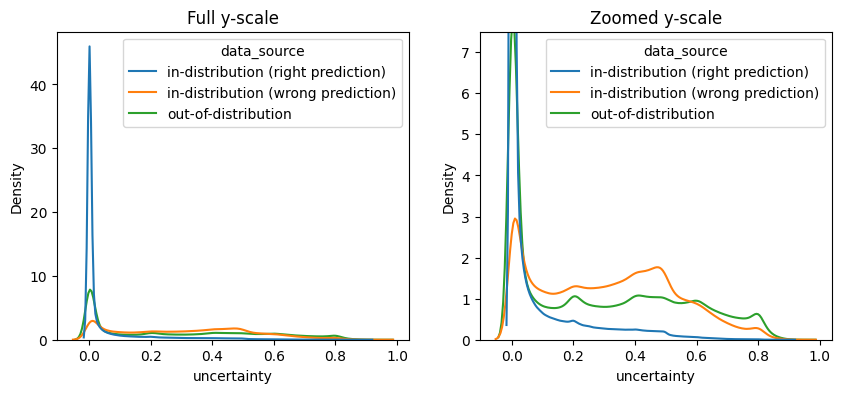

In [18]:
data = pd.DataFrame({
    'uncertainty': np.concatenate([
        1. - probas_right.max(axis=1), 
        1. - probas_wrong.max(axis=1), 
        1. - probas_ood.max(axis=1)
    ]),
    'data_source': np.repeat(
        ['in-distribution (right prediction)', 'in-distribution (wrong prediction)', 'out-of-distribution'], 
        [probas_right.shape[0], probas_wrong.shape[0], probas_ood.shape[0]]
    )
})

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].set_title('Full y-scale')
sns.kdeplot(x='uncertainty', hue='data_source', common_norm=False, data=data, ax=axs[0])
axs[1].set_title('Zoomed y-scale')
sns.kdeplot(x='uncertainty', hue='data_source', common_norm=False, data=data, ax=axs[1])
axs[1].set_ylim(0., 7.5);

del data

## Evaluate quality of uncertainty estimates

Goal:
* Use ROC curves to quantify how well right vs wrong predictions and known vs unknown cell types can be separated based on estimated uncertainties
* Evaluate how the quality of uncertainty estimates changes when increasing the number of models in the ensemble

Two evaluation cases:
1. Right vs wrong predictions (in-distribution)
2. Known (in-distribution) vs unknown (out-of-distribution) cell types

ROC curve: https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

In [20]:
def plot_roc_curve(probas_per_model_1, probas_per_model_2, ax, subsample_plot=30):
    assert probas_per_model_1.shape[-1] == probas_per_model_2.shape[-1]

    for n in range(1, probas_per_model_1.shape[-1] + 1):
        y = np.repeat(
            [True, False], 
            [probas_per_model_1.shape[0], probas_per_model_2.shape[0]]
        )
        x = np.concatenate([
            1. - probas_per_model_1[..., :n].mean(axis=-1).max(axis=1), 
            1. - probas_per_model_2[..., :n].mean(axis=-1).max(axis=1)
        ]).reshape((-1, 1))
        y_score = LogisticRegression(penalty=None).fit(x, y).predict_proba(x)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_score)
        ax.plot(
            fpr[::subsample_plot], tpr[::subsample_plot], 
            label=f'{n} ensembles: AUC = {roc_auc_score(y, y_score):.3f}'
        )

    ax.plot([0, 1], [0, 1], 'k--')
    ax.axis('square')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()


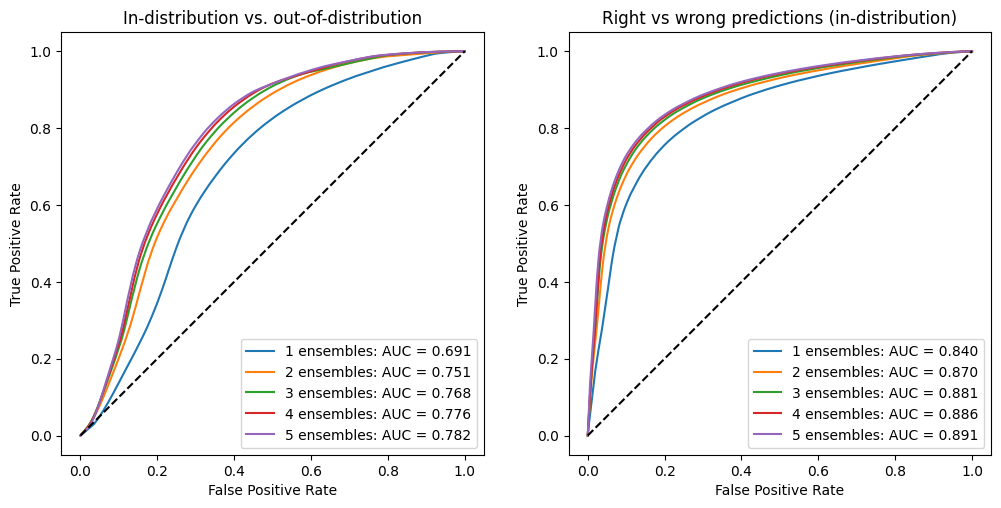

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
axs[0].set_title('In-distribution vs. out-of-distribution')
plot_roc_curve(probas_per_model[right_preds], probas_per_model_ood, axs[0])
axs[1].set_title('Right vs wrong predictions (in-distribution)')
plot_roc_curve(probas_per_model[right_preds], probas_per_model[wrong_preds], axs[1])

## TSNE visualization of uncertainty estimates

Visualize true labels, predicted labels and uncertainty estimates on top of TSNE embeddings of test data

In [22]:
import anndata
import scanpy as sc

from scipy.stats import entropy

In [23]:
adata = anndata.AnnData(
    X=np.load(join(DATA_PATH, 'pca/x_pca_test_50.npy')), 
    obs=pd.DataFrame({
        'y_true': cell_type_mapping.loc[y_true].to_numpy().flatten(), 
        'y_pred': cell_type_mapping.loc[y_pred_corr].to_numpy().flatten(),
        'uncertainty': 1. - probas.max(axis=1),
        'uncertainty_entropy': entropy(probas, axis=1) / np.log(probas.shape[1])
    })
)
adata.obs['wrong_prediction'] = (adata.obs.y_true != adata.obs.y_pred).astype(str).astype('category')


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [25]:
sc.pp.subsample(adata, n_obs=200_000)
sc.tl.tsne(adata, use_rep='X')

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


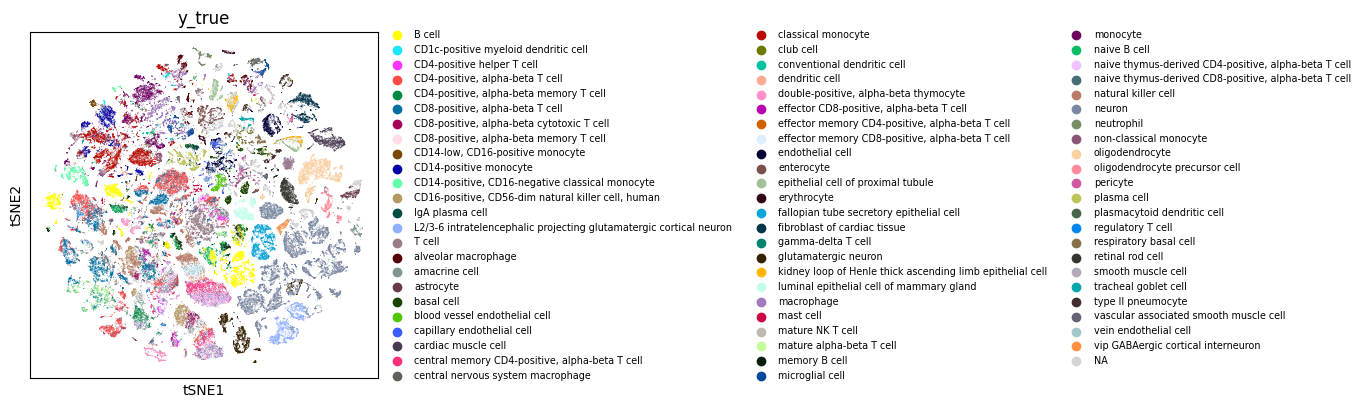

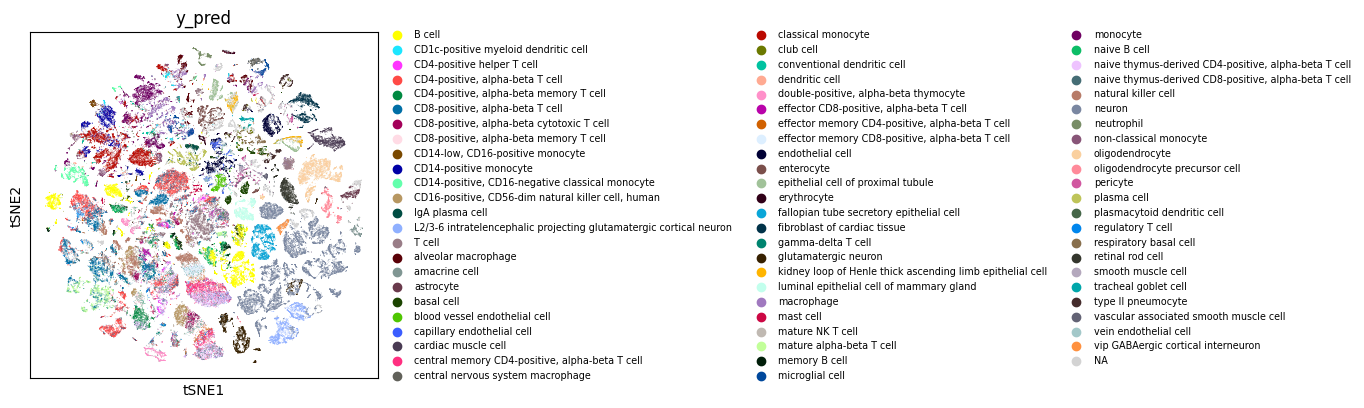

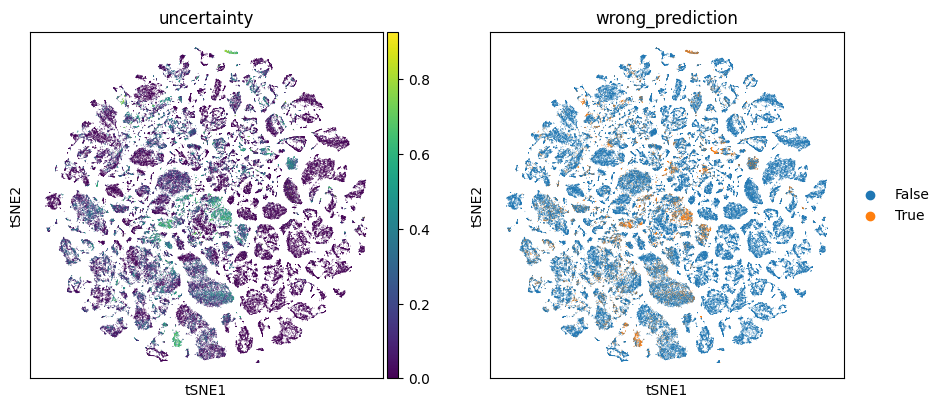

In [26]:
plt.rcParams['figure.figsize'] = (4.5, 4.5)

cell_freq = adata.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq[cell_freq > 500].index.tolist()
adata_plot = adata.copy()
adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.mask(~adata_plot.obs.y_pred.isin(cells_to_plot))
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))

sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata_plot, color='y_pred', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata_plot, color=['uncertainty', 'wrong_prediction'])